# DeepSAR demo

This notebook demonstrates the workflow for running DeepSAR, including model initialization, data processing, and prediction.

In Colab, please choose under "Resources" a GPU environment.

## Installation

In [1]:
!git clone https://github.com/vboussange/deepsar.git
!cd deepsar
!uv sync
!uv pip install torch --torch-backend=auto
!uv pip install -e .

fatal: destination path 'deepsar' already exists and is not an empty directory.
Resolved 99 packages in 11ms
Uninstalled 1 package in 0.93ms
 - deepsar==0.1.0 (from file:///home/boussang/NNSAR)
Audited 1 package in 4ms
Resolved 94 packages in 167ms                                        
   Building deepsar @ file:///home/boussang/NNSAR                      
   Building deepsar @ file:///home/boussang/NNSAR              
   Building deepsar @ file:///home/boussang/NNSAR              
      Built deepsar @ file:///home/boussang/NNSAR              
Prepared 1 package in 549ms                                              
Installed 1 package in 6msm file:///home/boussang/NNSAR)    
 + deepsar==0.1.0 (from file:///home/boussang/NNSAR)


In [4]:
import torch
import numpy as np
import xarray as xr
from pathlib import Path
from deepsar.data_processing.utils_env_pred import CHELSADataset
from deepsar.deep4pweibull import initialize_ensemble_model
from deepsar.plotting import CMAP_BR
import pandas as pd
from tqdm import tqdm

from scripts.train import Config


def create_raster(X_map, ypred):
    Xy_map = X_map.copy()
    Xy_map["pred"] = ypred
    rast = Xy_map["pred"].to_xarray().sortby(["y","x"])
    rast = xr.DataArray(rast.values, dims=["y", "x"], coords={
                            "x": rast.x.values,  # X coordinates (easting)
                            "y": rast.y.values,  # Y coordinates (northing)
                        },
                        name="pred")
    rast = rast.rio.write_crs("EPSG:3035")
    return rast

def plot_raster(rast, label, ax, cmap, vmin=None, vmax=None):
        # world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
        # world.boundary.plot(ax=ax, linewidth=0.1, edgecolor='black')
        cbar_kwargs = {'orientation':'horizontal', 'shrink':0.6, 'aspect':40, "label":"","pad":0.05, "location":"bottom"} #if display_cbar else {}
        # rolling window for smoothing
        rast.where(rast > 0.).plot(ax=ax,
                                    cmap=cmap,
                                    cbar_kwargs=cbar_kwargs,
                                    vmin=vmin,
                                    vmax=vmax)
        ax.set_title(label)
        ax.set_xlabel("")
        ax.set_ylabel("")


def create_features(predictor_labels, climate_dataset, res):
    # see: https://docs.xarray.dev/en/stable/generated/xarray.DataArray.coarsen.html
    resolution = abs(climate_dataset.rio.resolution()[0])
    ncells = max(1, int(res / resolution))
    coarse = climate_dataset.coarsen(x=ncells, y=ncells, boundary="trim")

    # See: https://corteva.github.io/rioxarray/stable/rioxarray.html#rioxarray.raster_array.RasterArray.reproject_match
    coarse_mean = coarse.mean().rio.write_crs("EPSG:3035")#.rio.reproject_match(ref)
    coarse_std = coarse.std().rio.write_crs("EPSG:3035")#.rio.reproject_match(ref)
    df_mean = coarse_mean.to_dataframe()
    df_std = coarse_std.to_dataframe()
    df_std = df_std.rename({col: "std_" + col for col in df_std.columns}, axis=1)
    X_map = pd.concat([df_mean, df_std], axis=1)

    X_map = X_map.assign(log_observed_area=np.log(res**2), log_megaplot_area=np.log(res**2))
    return X_map[predictor_labels]

# we use batches, otherwise model and data may not fit in memory
def get_SR_std_SR(model, climate_dataset, res, predictors, feature_scaler, target_scaler, batch_size=4096):
    """
    Calculate SR, std_SR and dlogSR_dlogA for the given model and climate
    dataset at a specified resolution. dSR is obtained as a gradient of SR with
    respect to log_megaplot_area. Does not account for changes in climate
    features with area.
    """
    mean_SR_list = []
    std_SR_list = []
    features = create_features(predictors, climate_dataset, res)
    total_length = len(features)

    percent_step = max(1, total_length // batch_size // 100)

    for i in tqdm(range(0, total_length, batch_size), desc = "Calculating SR and stdSR", miniters=percent_step, maxinterval=float("inf")):
        with torch.no_grad():
            current_batch_size = min(batch_size, total_length - i)
            # features = get_true_sar.interpolate_features(X_map_dict, log_area_tensor, res_climate_pixel, predictors, batch_index=slice(i, i + current_batch_size))
            X = features.iloc[i:i+current_batch_size,:]
            X = feature_scaler.transform(X.values)
            X = torch.tensor(X, dtype=torch.float32).to(next(model.parameters()).device)
            ys = [m.predict_sr(X[:, 1:]) for m in model.models] # predicting asymptote, no need to feed log_observed_area
            SRs = [target_scaler.inverse_transform(y.cpu().numpy()) for y in ys]
            mean_SR = np.mean(SRs, axis=0)
            std_SR = np.std(SRs, axis=0)
            mean_SR_list.append(mean_SR)
            std_SR_list.append(std_SR)

    mean_SR = np.concatenate(mean_SR_list, axis=0)
    std_SR = np.concatenate(std_SR_list, axis=0)
    return features, mean_SR, std_SR


def load_chelsa_and_reproject(predictors):
    climate_dataset = xr.open_dataset(CHELSADataset().cache_path)
    climate_dataset = climate_dataset[[v for v in climate_dataset.data_vars if v in predictors]]
    climate_dataset = climate_dataset.rio.reproject("EPSG:3035")
    return climate_dataset


## Loading model and environmental features

In [ ]:
MODEL_NAME = "0b85791"
plotting = True

path_results = Path(f"scripts/results/train/deepsar_ensemble_weights_{MODEL_NAME}.pth")
results_fit_split = torch.load(path_results, map_location="cpu", weights_only=False)
config = results_fit_split["config"]

predictors = results_fit_split["predictors"]
feature_scaler = results_fit_split["feature_scaler"]
target_scaler = results_fit_split["target_scaler"]

model = initialize_ensemble_model(results_fit_split["ensemble_model_state_dict"], predictors, config)
climate_dataset = load_chelsa_and_reproject(predictors)

/home/boussang/NNSAR/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/boussang/NNSAR/.venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator MaxAbsScaler from version 1.5.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/boussang/NNSAR/.venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=o

KeyboardInterrupt: 

/home/boussang/NNSAR/.venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/boussang/NNSAR/.venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/boussang/NNSAR/.venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/boussang/NNSAR/.venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/boussang/NNSAR/.venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=d

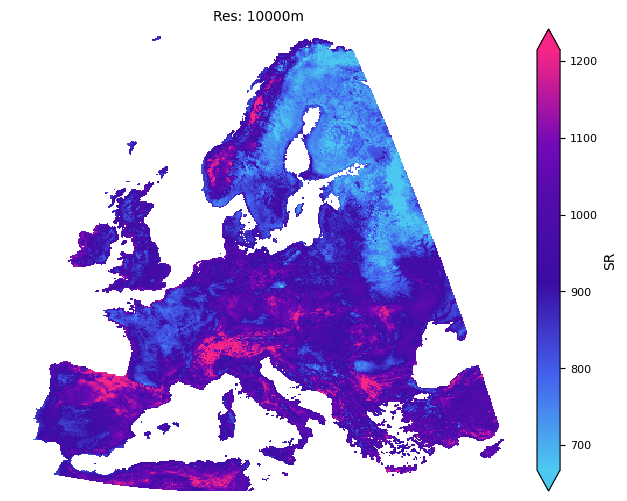

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
    
res = 10000

features, SR, std_SR = get_SR_std_SR(model, climate_dataset, res, predictors, feature_scaler, target_scaler)

SR_rast = create_raster(features, SR)
    
# plotting
fig, ax = plt.subplots(figsize=(8, 6))
# colors = ["#dad7cd","#a3b18a","#588157","#3a5a40","#344e41"]
SR_rast = SR_rast.rename("SR")
SR_rast.plot(ax=ax, cmap=CMAP_BR, vmin=SR_rast.quantile(0.01), vmax=SR_rast.quantile(0.99))
ax.set_title(f"Res: {res}m")
ax.set_axis_off()


## Saving raster

In [ ]:
SR_rast.rio.to_raster(f"SR_raster_{MODEL_NAME}_{res:.0f}m.tif")